**Welcome to the Tutorial on Dimensionality Reduction Techniques for Machine Learning**

*The aim of this tutorial is to show how PCA can be used in assisting machine learning algorithms to significantly reduce the model complexity without compromising the model accuracy. Linear regression is used as a model of choice with polynomial features of order 3.*

*For this task, we will take a look at the [Physicochemical Properties of Protein Tertiary Structure Data Set](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure) dataset. This is a dataset of Physicochemical Properties of Protein Tertiary Structure.* 

*The tutorial is divided into three sections:*
> 1. *Data preprocessing. Explore the dataset for statistical attributes*
> 2. *Fit a linear model and evaluate performance*
> 3. *Project the feature space onto a reduced one with at least 99% of variance preserved*
> 4. *Fit a linear model on the reduced features and evaluate performance*

# Preprocessing

Load all the relevant modules. Load the data into pandas dataframe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


It is often a good idea to start gathering all information about the data we are trying to use. We will try to extract three layers of information from this dataset. Just to make it easier for us to do this, it is a good idea to wrap these commands into a function **get_dataset_details**. 

Here is a function that prints all the relevant details about the data.

* df.info() provides details about the non-null entries in each column of the dataframe
* df.describe() lists down all the relevant statistical features about the dataset like count, mean, standard deviation
* df.hist(), with "bins" argument, plots how each of the features are distrbuted

In [3]:
def get_dataset_details(df):
    print(df.info(),'\n')
    print(df.describe(),'\n')
    df.hist(bins=50, figsize=(15,15))
    plt.show();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB
None 

               RMSD            F1            F2            F3            F4  \
count  45730.000000  45730.000000  45730.000000  45730.000000  45730.000000   
mean       7.748528   9871.596995   3017.367175      0.302392    103.492433   
std        6.118312   4058.138034   1464.324663      0.062886     55.424985   
min        0.000000   2392.050000    403.500000      0.092500     10.31010

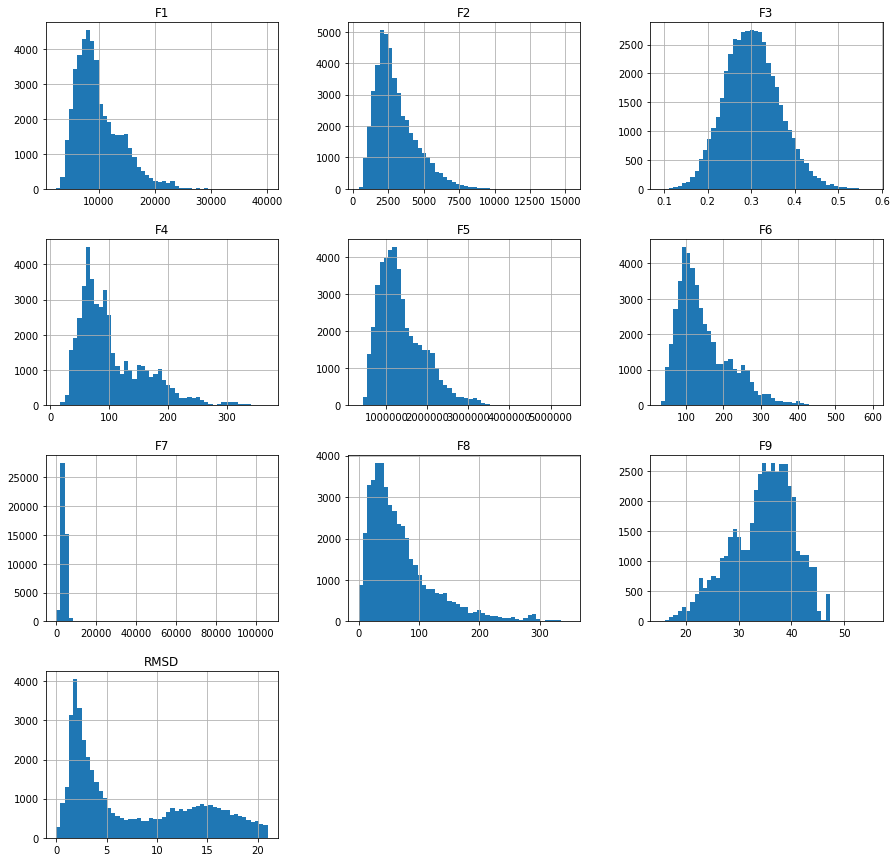

In [4]:
get_dataset_details(casp)

Let us see if there is any missing data in the dataset

In [5]:
np.where(casp.values == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [6]:
def get_correlation(data, get_RMSD_corr=False):
    plt.figure(figsize=(15,15));
    plt.matshow(data.corr(), cmap = 'jet');
    plt.colorbar();
    pd.plotting.scatter_matrix(data, figsize=(16,10));
    if get_RMSD_corr:
        print(data.corr()["RMSD"].sort_values(ascending=False));

get_correlation(casp, True)

# Fit a linear regression model without using PCA

Let us start with splitting the dataset into training set and test set. We will make use of Pipeline function from scikitlearn to be able to do scaling of the data and add polynomial features. 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp.drop("RMSD", axis=1),casp["RMSD"], test_size=0.3, random_state=42)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
])

poly_features_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("minmax_scaler", MinMaxScaler())
])

X_train_scaled = poly_features_pipeline.fit_transform(X_train)
y_train_scaled = scaler_pipeline.fit_transform(y_train.values.reshape(-1,1))

In [20]:
X_train_scaled.shape

(32011, 219)

In [21]:
print("Number of Features in the set " + str(X_train_scaled.shape[1]))

Number of Features in the set 219


We ended up with 219 features altogether. How did this happen? 

The formula to calculate the total number of polynomial features after transormation is *C(n+r,r)* (Combination), where *n* is the number of features in the dataset and *r* is the degree of polynomial. In our case, this translates to $C(9+3,3) = 12!/ (12-3)! 3! = 220$. Since we did not opt for the bias term, we ended up with one less than 220, i.e., 219.

In [22]:
from sklearn.linear_model import LinearRegression
import time
lin_reg = LinearRegression();

start_time = time.time()
lin_reg.fit(X_train_scaled, y_train_scaled)
print('Time taken ' + str(time.time() - start_time))

Time taken 0.7778120040893555


In [23]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(10,6))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [24]:
X_test_scaled = poly_features_pipeline.fit_transform(X_test)
y_test_scaled = scaler_pipeline.fit_transform(y_test.values.reshape(-1,1))

In [25]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(lin_reg.predict(X_test_scaled),y_test_scaled))
rmse_train = np.sqrt(mean_squared_error(lin_reg.predict(X_train_scaled),y_train_scaled))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  0.21892873669337348 1.9862533000991316


In [26]:
r2_model_score = r2_score(lin_reg.predict(X_test_scaled), y_test_scaled)

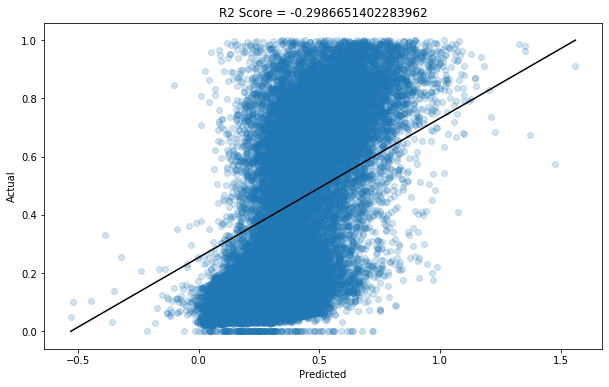

In [27]:
plot_results(X_train_scaled, y_train_scaled, lin_reg, "Without_PCA_Train")

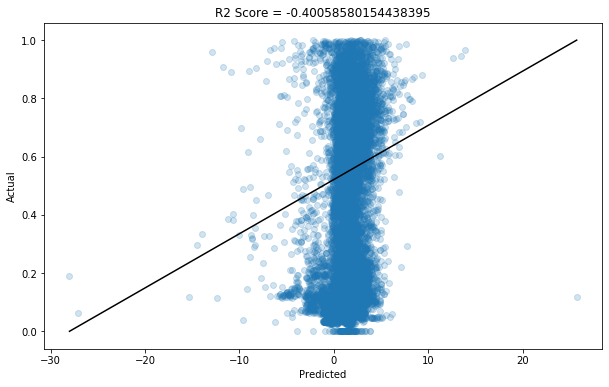

In [28]:
plot_results(X_test_scaled, y_test_scaled, lin_reg, "Without_PCA_Test")

# Use PCA

In [31]:
from sklearn.decomposition import PCA

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
])

pca_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.99))
])

X_train_scaled = pca_pipeline.fit_transform(X_train)
y_train_scaled = scaler_pipeline.fit_transform(y_train.values.reshape(-1,1))

In [43]:
pca_handle = pca_pipeline['pca']
pca_handle.explained_variance_ratio_.sum()

0.9908525755765909

In [35]:
X_train_scaled.shape

(32011, 10)

In [49]:
X_proj = X_train_scaled

In [50]:
X_proj.shape

(32011, 10)

In [51]:
lin_reg_pca = LinearRegression()
start_time = time.time()
lin_reg_pca.fit(X_proj, y_train_scaled)
print("time taken to fit = ", time.time()-start_time)

time taken to fit =  0.01510310173034668


In [52]:
rmse_X_scaled = np.sqrt(mean_squared_error(lin_reg_pca.predict(X_proj),y_train_scaled))
print("RMSE is ",rmse_X_scaled)

RMSE is  0.2501671592224569


In [53]:
X_test_scaled = pca_pipeline.fit_transform(X_test)
y_test_scaled = scaler_pipeline.fit_transform(y_test.values.reshape(-1,1))

In [48]:
X_test_proj = pca_handle.transform(X_test_scaled)

ValueError: operands could not be broadcast together with shapes (13719,10) (219,) 

In [56]:
rmse_test = np.sqrt(mean_squared_error(lin_reg_pca.predict(X_test_scaled),y_test_scaled))
print("RMSE on test set is ", rmse_test)

RMSE on test set is  0.262816639670615


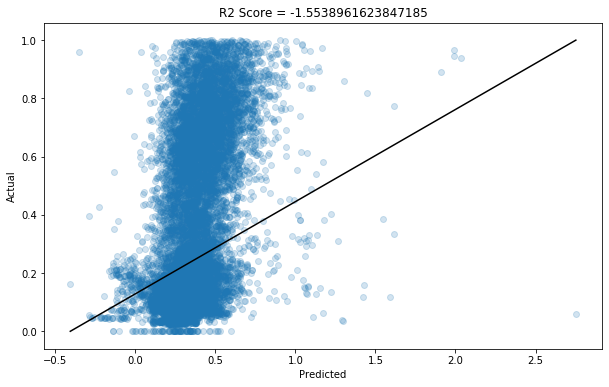

In [58]:
plot_results(X_test_scaled, y_test_scaled, lin_reg_pca, "With_PCA")